# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytest
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc)


# Load Dataset and Overview 

In [2]:
df = pd.read_csv("diabetes (1).csv")  
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# Check missing or zero values
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

# Exploratory Data Analysis (EDA)

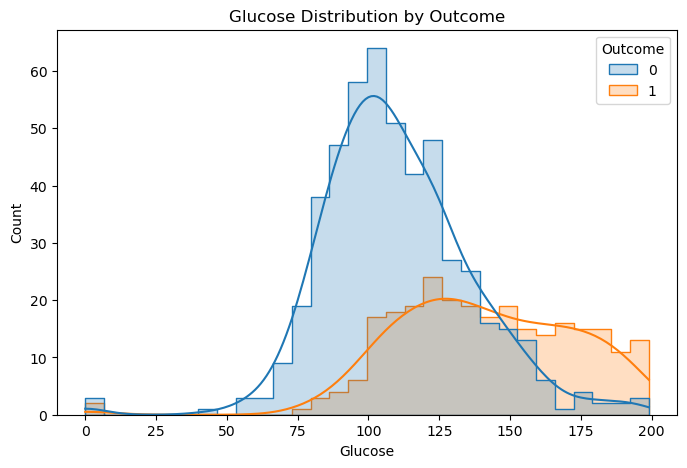

In [6]:
# Glucose Distribution by Outcome
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="Glucose", hue="Outcome", bins=30, kde=True, element="step")
plt.title("Glucose Distribution by Outcome")
plt.show()

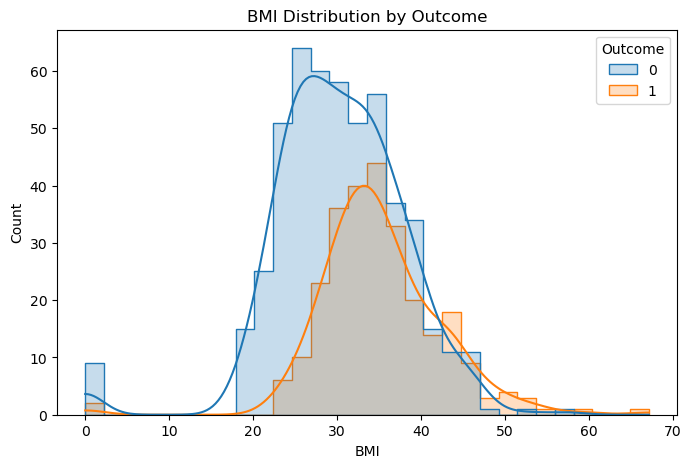

In [7]:
# BMI Distribution by Outcome
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="BMI", hue="Outcome", bins=30, kde=True, element="step")
plt.title("BMI Distribution by Outcome")
plt.show()

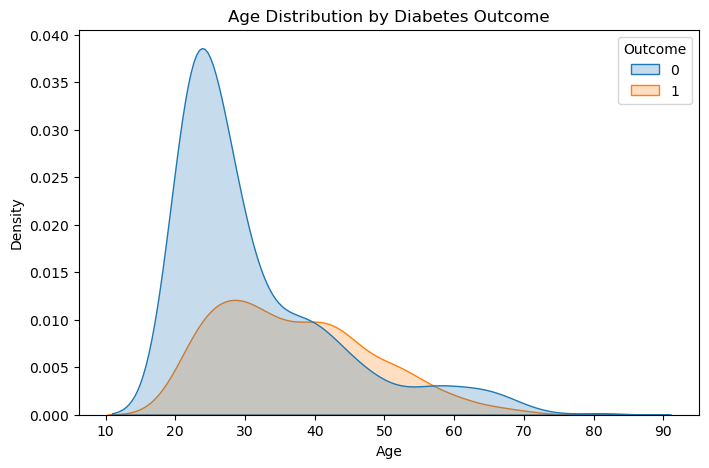

In [8]:
# Age Distribution by Outcome
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="Age", hue="Outcome", fill=True)
plt.title("Age Distribution by Diabetes Outcome")
plt.show()


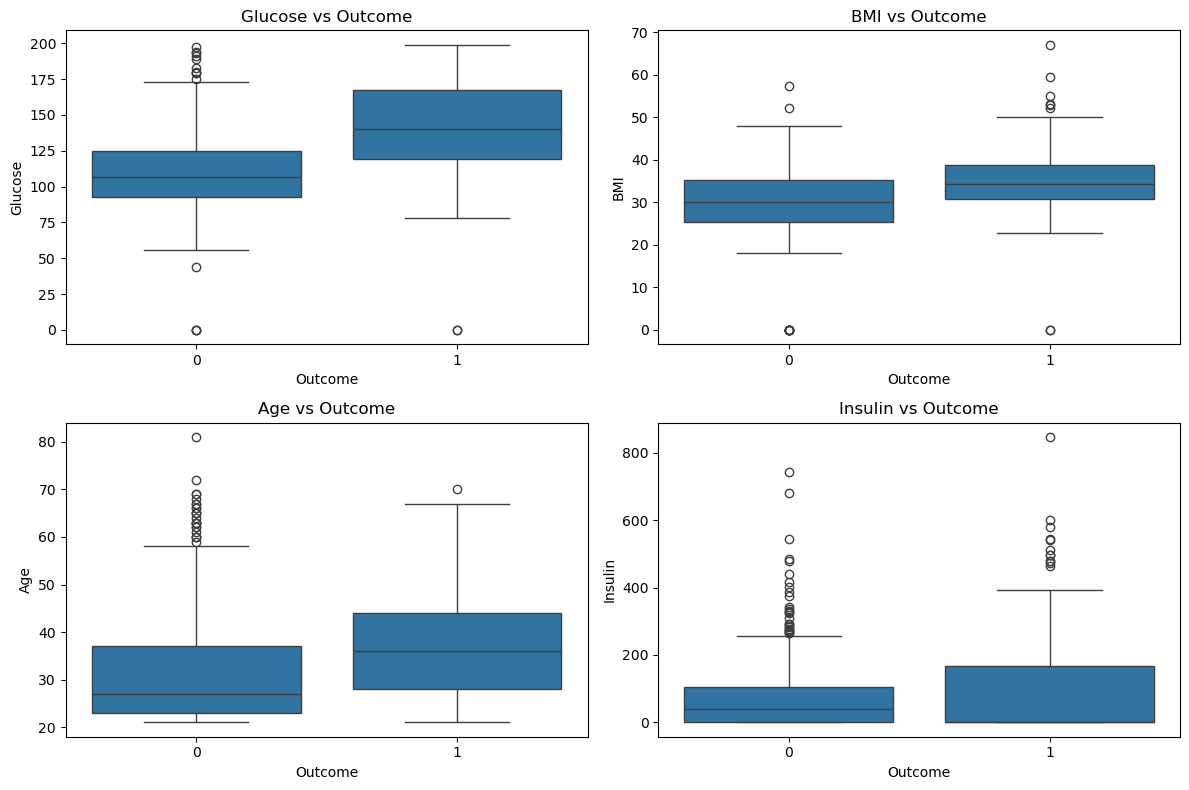

In [9]:
# Boxplots for Key Features
features_to_plot = ["Glucose", "BMI", "Age", "Insulin"]

plt.figure(figsize=(12,8))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x="Outcome", y=col, data=df)
    plt.title(f"{col} vs Outcome")
plt.tight_layout()
plt.show()

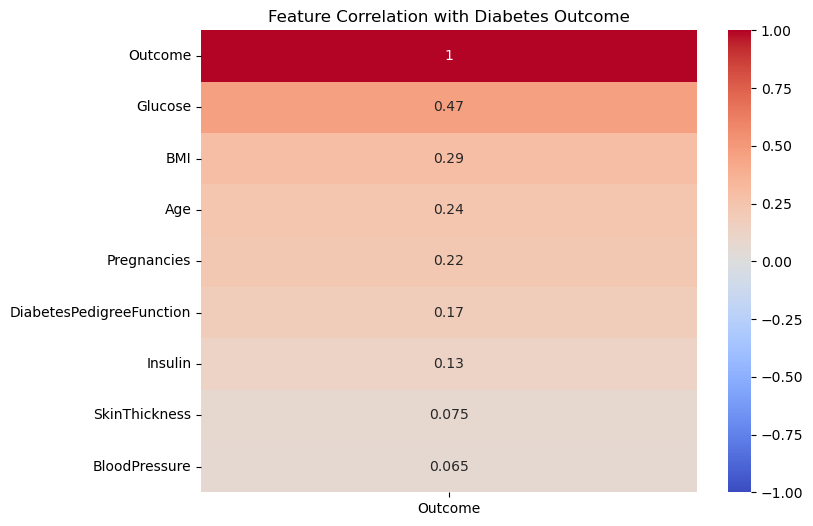

In [10]:
# Correlation Heatmap
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr[['Outcome']].sort_values(by='Outcome', ascending=False), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation with Diabetes Outcome")
plt.show()


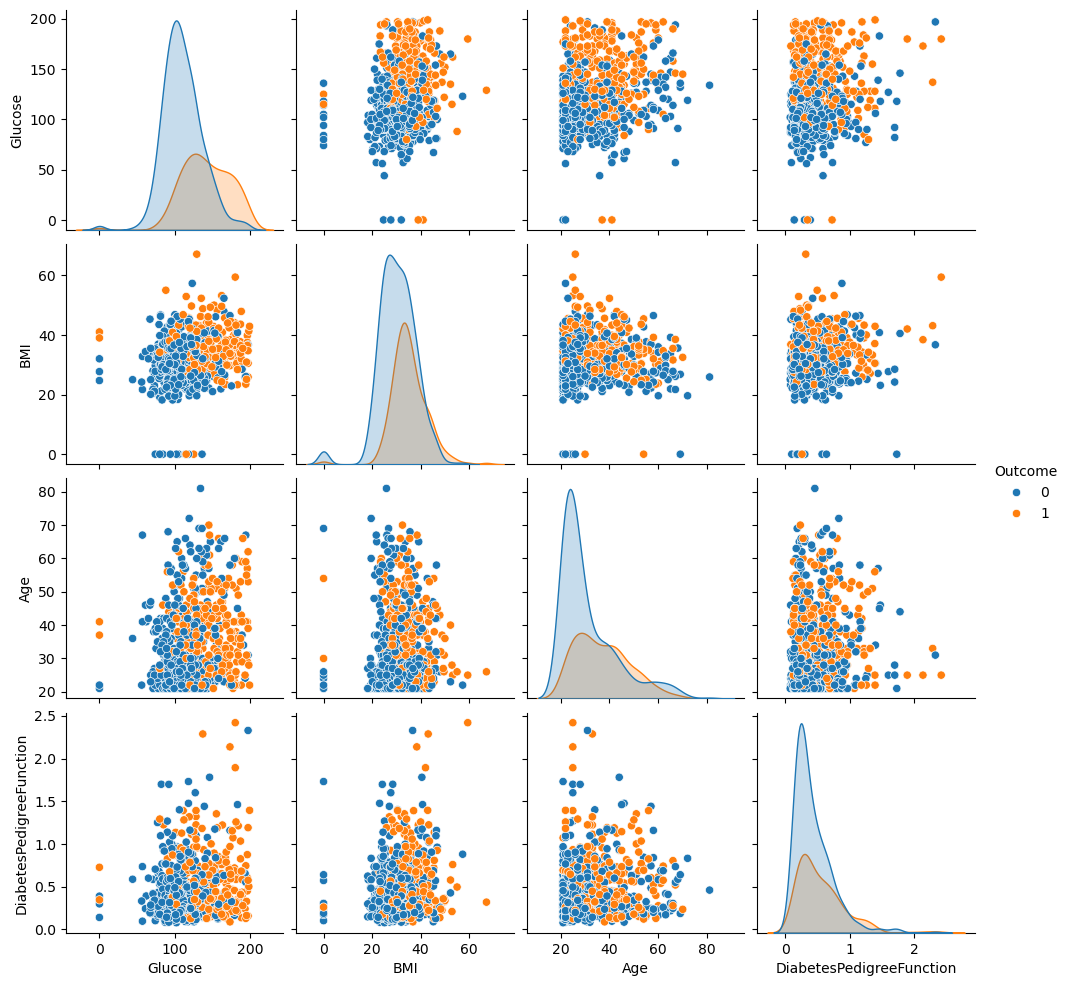

In [11]:
# Pairplot
sns.pairplot(df[["Glucose","BMI","Age","DiabetesPedigreeFunction","Outcome"]], hue="Outcome")
plt.show()


# Data Preprocessing

In [12]:
# Replace 0 with NaN for some columns
cols_with_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

In [13]:
imputer = SimpleImputer(strategy="median")
df[cols_with_zero] = imputer.fit_transform(df[cols_with_zero])

In [14]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [15]:
# Split features/target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [16]:
# Preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_processed = preprocessor.fit_transform(X)


# Train/Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

# Model Training

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, proba)

    print(f"### {name} ###")
    print("Accuracy:", acc)
    print("ROC-AUC:", roc)
    print(classification_report(y_test, preds))
    
    results[name] = {"model": model, "accuracy": acc, "roc_auc": roc}


### Logistic Regression ###
Accuracy: 0.7012987012987013
ROC-AUC: 0.8127777777777777
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154

### Random Forest ###
Accuracy: 0.7402597402597403
ROC-AUC: 0.8173148148148148
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154

### Gradient Boosting ###
Accuracy: 0.7597402597402597
ROC-AUC: 0.8251851851851851
              precision    recall  f1-score   support

           0       0.81      0.83      0.82 

# ROC Curve Comparison

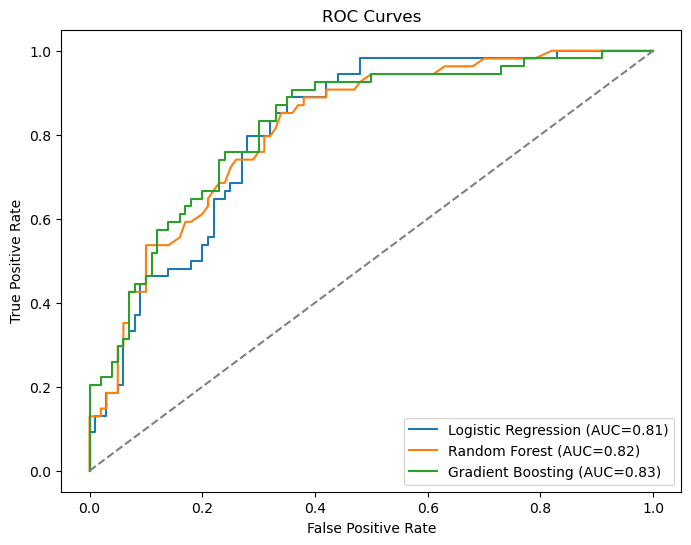

In [19]:
plt.figure(figsize=(8,6))
for name, info in results.items():
    model = info['model']
    proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={info['roc_auc']:.2f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


# Cross-Validation

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, info in results.items():
    scores = cross_val_score(info['model'], X_processed, y, cv=cv, scoring='roc_auc')
    print(f"{name} CV ROC-AUC Mean:", scores.mean())

Logistic Regression CV ROC-AUC Mean: 0.8366268343815513
Random Forest CV ROC-AUC Mean: 0.8261194968553459
Gradient Boosting CV ROC-AUC Mean: 0.8251243885394828


# Save Best Model

In [21]:
import joblib

best_model = max(results.items(), key=lambda x: x[1]['roc_auc'])[1]['model']
joblib.dump(best_model, "best_model.joblib")
print("Best model saved as best_model.joblib")

Best model saved as best_model.joblib


# Unit Testing of Preprocessing and Model

In [22]:
# Test 1: Preprocessing replaces zeros with NaN
df_test = pd.DataFrame({
    "Pregnancies":[1,2],
    "Glucose":[0,150],
    "BloodPressure":[0,80],
    "SkinThickness":[0,20],
    "Insulin":[0,90],
    "BMI":[0,32],
    "DiabetesPedigreeFunction":[0.3,0.5],
    "Age":[25,40],
    "Outcome":[0,1]
})

df_test_replaced = df_test.copy()
cols_with_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df_test_replaced[cols_with_zero] = df_test_replaced[cols_with_zero].replace(0, np.nan)

assert df_test_replaced.isnull().sum().sum() > 0, "Zeros were not replaced with NaN!"

print(" Test 1 passed: preprocessing replaces zeros correctly.")

 Test 1 passed: preprocessing replaces zeros correctly.


In [23]:
# Test 2: Preprocessing pipeline output shape
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_test = df_test_replaced.drop("Outcome", axis=1)
X_trans = pipeline.fit_transform(X_test)
assert X_trans.shape[1] == X_test.shape[1], "Shape mismatch after preprocessing!"

print("Test 2 passed: preprocessing pipeline keeps correct feature shape.")

Test 2 passed: preprocessing pipeline keeps correct feature shape.


In [24]:
#  Test 3: Model can fit and predict
y_test = df_test_replaced["Outcome"]

model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500))
])

model.fit(X_test, y_test)
preds = model.predict(X_test)

assert len(preds) == len(y_test), "Prediction length mismatch!"
print(" Test 3 passed: model can train and predict.")

 Test 3 passed: model can train and predict.


# Workflow Validation (End-to-End Check)

In [25]:
def full_workflow_check(df):
    """
    Mini end-to-end test of workflow: preprocess -> split -> train -> predict
    """
    from sklearn.model_selection import train_test_split

    X = df.drop("Outcome", axis=1)
    y = df["Outcome"]

    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=500))
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pipeline.fit(X_train, y_train)
    acc = pipeline.score(X_test, y_test)
    return acc

# Run on main dataset
acc = full_workflow_check(df)
print(f" End-to-end workflow test passed. Accuracy: {acc:.3f}")

 End-to-end workflow test passed. Accuracy: 0.708
